In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os


from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [ ]:
!pwd
#data_folder_path = './data/'
data_folder_path = '/content/drive/MyDrive/toxic-comment-classification/data/'
df = pd.read_csv(data_folder_path + 'train.csv')
test_text = pd.read_csv(data_folder_path + 'test.csv')
test_label = pd.read_csv(data_folder_path + 'test_labels.csv')
test_df = pd.concat([test_text, test_label], axis=1)
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

/content


In [ ]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)
test_df['comment_text'] = test_df['comment_text'].apply(data_cleaning)

In [ ]:
test_df[0:20]
ids_to_drop = []
for i in range(len(test_df)):
    if test_df['toxic'][i] == -1 or test_df['severe_toxic'][i] == -1 or test_df['obscene'][i] == -1 or test_df['threat'][i] == -1 or test_df['insult'][i] == -1 or test_df['identity_hate'][i] == -1:
        ids_to_drop.append(i)

test_df = test_df.drop(ids_to_drop)

test_df.head()

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding I think very highl...,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,""" It says it even in Binghamton Universit...",0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,""" == Before adding a new product to the l...",00059ace3e3e9a53,0,0,0,0,0,0


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
from torchtext.vocab import GloVe, vocab

unk_token = "<pad>"
unk_index = 0
#name = "vector_cache"


if os.path.isdir("/content/drive/MyDrive/toxic-comment-classification/.vector_cache"):
    glove_vectors = GloVe(name = 'twitter.27B', cache = './.vector_cache', dim=200)
else:    
    glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


./.vector_cache/glove.twitter.27B.zip: 1.52GB [04:45, 5.33MB/s]                            
100%|█████████▉| 1193513/1193514 [01:16<00:00, 15615.25it/s]


1193514
torch.Size([1193515, 200])


In [ ]:
from torch.utils.data import IterableDataset

tokenizer = get_tokenizer("basic_english")



class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]

        diff = self.max_len - len(tokens)
        # print('diff',diff)
        if diff > 0:

            tokens = [self.pad_token] * diff + tokens
            # print('tokens',to
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [ ]:
MAX_LEN = 0
for a in range(0 , len(df)):
    f = df["comment_text"][a]
    length = len(f.split())
    if length > MAX_LEN:
        MAX_LEN = length
        
train_dataset = MyDataset(df, MAX_LEN)
test_dataset = MyDataset(test_df, MAX_LEN)

In [ ]:
postive_num = [0, 0, 0, 0, 0, 0]
negative_num = [0, 0, 0, 0, 0, 0]
for data in train_dataset:
    class_num = 0
    for i in data['labels'].tolist():
      if i == 0:
        negative_num[class_num] += 1
      else:
        postive_num[class_num] += 1
      class_num += 1


In [ ]:
print(postive_num)
print(negative_num)

[15294, 1595, 8449, 478, 7877, 1405]
[144277, 157976, 151122, 159093, 151694, 158166]


In [ ]:
import numpy as np

pos_weight_set = [0, 0, 0, 0, 0, 0]
neg_weight_set = [0, 0, 0, 0, 0, 0]
weight_set = [0, 0, 0, 0, 0, 0]
weight_set_sqrt = [0, 0, 0, 0, 0, 0]
for num in range(len(postive_num)):
  #weight_set[num] = negative_num[num] / postive_num[num]
  pos_weight_set[num] = (1 - 0.9999) / (1 - np.power(0.9999, postive_num[num]))
  neg_weight_set[num] = (1 - 0.9999) / (1 - np.power(0.9999, negative_num[num]))
  weight_set[num] =  pos_weight_set[num] / neg_weight_set[num]
  weight_set_sqrt[num] =  np.sqrt(negative_num[num] / postive_num[num])
print("pos_weight_set: ", pos_weight_set)
print("neg_weight_set: ", neg_weight_set)
print("weight_set: ", weight_set)
print("weight_set_sqrt: ", weight_set_sqrt)

pos_weight_set:  [0.00012765670498582926, 0.0006782565689779384, 0.00017531008706273365, 0.0021423439430321733, 0.0001834431287148764, 0.0007628786912533018]
neg_weight_set:  [0.00010000005417717257, 0.00010000001376721648, 0.00010000002732289386, 0.00010000001231212383, 0.0001000000258038074, 0.00010000001350809561]
weight_set:  [1.2765663582507336, 6.782564756009011, 1.7531003916295773, 21.423436792641667, 1.8344308137957697, 7.6287858820293275]
weight_set_sqrt:  [3.071411519116151, 9.952111037693614, 4.229228899698583, 18.243643932423545, 4.388375471505747, 10.610073773561947]


In [ ]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=4, bidirectional=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)
        
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out

In [ ]:
'''
import torch.nn.functional as F

class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=4, bidirectional=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)
        self.attn = nn.Linear(hidden_size, hidden_size)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)
        print("lstm_out size: ", lstm_out.size())
        x = lstm_out.squeeze()
        content_vectors = [x[0].view(1, -1)]
        # for-loop over hidden states and attention
        for i in range(1, x.size(0)):
            prev_states = x[:i]
            current_state = x[i].view(1, -1)
            atten = self.attn(current_state)
            attn_prod = torch.mm(atten, prev_states.t())
            attn_weights = F.softmax(attn_prod, dim=1)
            context = torch.mm(attn_weights, prev_states)
            content_vectors.append(context)

        
        #encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)

        encoding = torch.cat(content_vectors)
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)
        

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out
'''

In [ ]:
train_dataset

In [ ]:
## OK let's try to run this model to see if dimensions are correct!
#glove_model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64, is_batch=False)

#for idx, data in enumerate(train_dataset):
#    print("---------------------------------")
#    print('next example id ', idx)
#    print("---------------------------------")
#    # example_text = data['text']
#    text_input = data['indices']
    # print('tensor_shape: ', text_input.shape)
#    model_output = glove_model(text_input)
    # fwd = glove_model.forward(text_input)
    # print('embedding_bag: ',  fwd.shape)
    # print('output_shape: ', model_output.shape)
#    print('output: ', model_output)

    #if idx == 2:
#    break

In [ ]:
from torch.utils.data import DataLoader


BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

               precision    recall  f1-score   support

        toxic       0.75      0.05      0.10      6090
 severe_toxic       0.32      0.11      0.17       367
      obscene       0.71      0.05      0.09      3691
       threat       0.21      0.13      0.16       211
       insult       0.67      0.05      0.09      3427
identity_hate       0.20      0.02      0.03       712

    micro avg       0.60      0.05      0.09     14498
    macro avg       0.48      0.07      0.10     14498
 weighted avg       0.68      0.05      0.09     14498
  samples avg       0.00      0.00      0.00     14498

Epoch: 0 Train_Loss: 0.27383819482742977 Train_Accuracy: 0.962478518486023
Epoch: 0 Test_Loss: 0.2304724873304367 Test_Accuracy: 0.9628570675849915


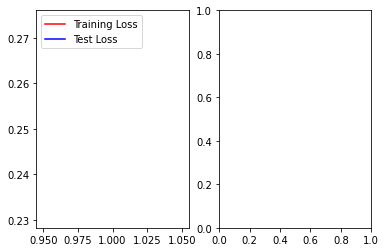

               precision    recall  f1-score   support

        toxic       0.73      0.24      0.37      6090
 severe_toxic       0.20      0.51      0.29       367
      obscene       0.72      0.27      0.39      3691
       threat       0.14      0.41      0.21       211
       insult       0.65      0.26      0.37      3427
identity_hate       0.24      0.16      0.19       712

    micro avg       0.55      0.26      0.35     14498
    macro avg       0.45      0.31      0.30     14498
 weighted avg       0.66      0.26      0.36     14498
  samples avg       0.02      0.02      0.02     14498

Epoch: 1 Train_Loss: 0.19766782422382861 Train_Accuracy: 0.965688169002533
Epoch: 1 Test_Loss: 0.19964370703697204 Test_Accuracy: 0.9641100764274597


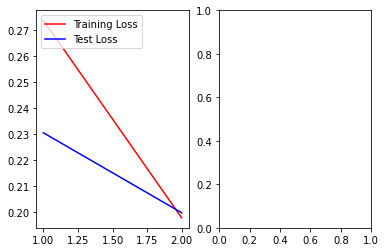

               precision    recall  f1-score   support

        toxic       0.64      0.38      0.47      6090
 severe_toxic       0.18      0.65      0.29       367
      obscene       0.64      0.40      0.49      3691
       threat       0.35      0.25      0.29       211
       insult       0.57      0.39      0.46      3427
identity_hate       0.22      0.26      0.24       712

    micro avg       0.53      0.38      0.45     14498
    macro avg       0.43      0.39      0.37     14498
 weighted avg       0.59      0.38      0.46     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 2 Train_Loss: 0.17431911004659456 Train_Accuracy: 0.968115508556366
Epoch: 2 Test_Loss: 0.1879344921708107 Test_Accuracy: 0.9639902710914612


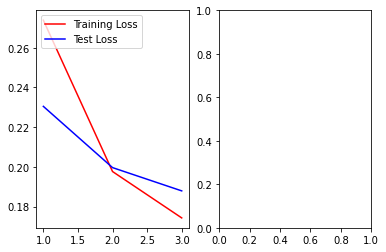

               precision    recall  f1-score   support

        toxic       0.70      0.34      0.46      6090
 severe_toxic       0.25      0.57      0.35       367
      obscene       0.69      0.39      0.50      3691
       threat       0.20      0.47      0.28       211
       insult       0.64      0.37      0.47      3427
identity_hate       0.28      0.16      0.20       712

    micro avg       0.59      0.36      0.45     14498
    macro avg       0.46      0.38      0.38     14498
 weighted avg       0.65      0.36      0.45     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 3 Train_Loss: 0.163213618648931 Train_Accuracy: 0.9697052240371704
Epoch: 3 Test_Loss: 0.17754798331856728 Test_Accuracy: 0.9665250182151794


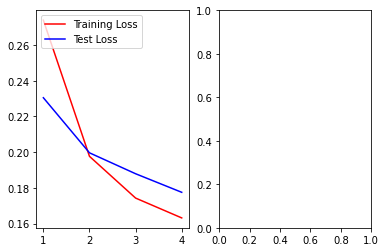

               precision    recall  f1-score   support

        toxic       0.74      0.36      0.48      6090
 severe_toxic       0.24      0.60      0.34       367
      obscene       0.73      0.40      0.52      3691
       threat       0.21      0.50      0.30       211
       insult       0.69      0.36      0.48      3427
identity_hate       0.25      0.27      0.26       712

    micro avg       0.61      0.38      0.46     14498
    macro avg       0.48      0.41      0.40     14498
 weighted avg       0.68      0.38      0.47     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 4 Train_Loss: 0.15480115700465363 Train_Accuracy: 0.97077476978302
Epoch: 4 Test_Loss: 0.17224472749233247 Test_Accuracy: 0.9671996831893921


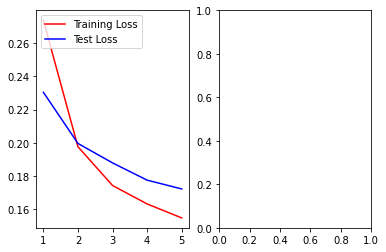

               precision    recall  f1-score   support

        toxic       0.70      0.43      0.53      6090
 severe_toxic       0.24      0.60      0.34       367
      obscene       0.67      0.48      0.56      3691
       threat       0.22      0.51      0.31       211
       insult       0.64      0.44      0.52      3427
identity_hate       0.26      0.30      0.28       712

    micro avg       0.59      0.44      0.50     14498
    macro avg       0.46      0.46      0.42     14498
 weighted avg       0.64      0.44      0.52     14498
  samples avg       0.03      0.04      0.03     14498

Epoch: 5 Train_Loss: 0.14679086424458104 Train_Accuracy: 0.9716719388961792
Epoch: 5 Test_Loss: 0.16372785302996634 Test_Accuracy: 0.9671658277511597


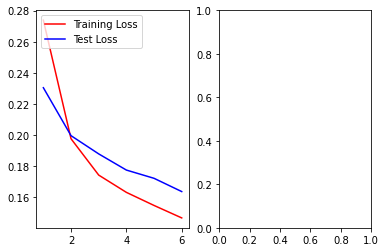

               precision    recall  f1-score   support

        toxic       0.70      0.44      0.54      6090
 severe_toxic       0.22      0.62      0.33       367
      obscene       0.73      0.45      0.55      3691
       threat       0.24      0.54      0.33       211
       insult       0.70      0.41      0.51      3427
identity_hate       0.29      0.31      0.30       712

    micro avg       0.61      0.43      0.50     14498
    macro avg       0.48      0.46      0.43     14498
 weighted avg       0.67      0.43      0.52     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 6 Train_Loss: 0.14060425413294864 Train_Accuracy: 0.9723780155181885
Epoch: 6 Test_Loss: 0.16126049423217773 Test_Accuracy: 0.9679603576660156


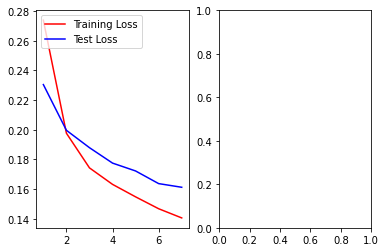

               precision    recall  f1-score   support

        toxic       0.70      0.47      0.56      6090
 severe_toxic       0.20      0.68      0.30       367
      obscene       0.69      0.50      0.58      3691
       threat       0.23      0.55      0.32       211
       insult       0.65      0.45      0.54      3427
identity_hate       0.31      0.30      0.30       712

    micro avg       0.59      0.47      0.52     14498
    macro avg       0.46      0.49      0.44     14498
 weighted avg       0.65      0.47      0.54     14498
  samples avg       0.04      0.04      0.03     14498

Epoch: 7 Train_Loss: 0.13684706112895256 Train_Accuracy: 0.9729514122009277
Epoch: 7 Test_Loss: 0.1589200748503208 Test_Accuracy: 0.9676086902618408


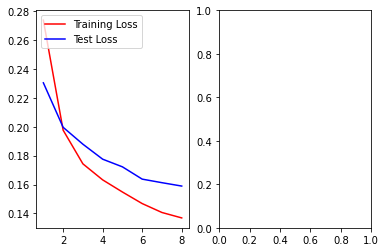

               precision    recall  f1-score   support

        toxic       0.65      0.53      0.58      6090
 severe_toxic       0.18      0.72      0.28       367
      obscene       0.64      0.56      0.60      3691
       threat       0.19      0.60      0.28       211
       insult       0.59      0.53      0.56      3427
identity_hate       0.28      0.40      0.33       712

    micro avg       0.54      0.54      0.54     14498
    macro avg       0.42      0.56      0.44     14498
 weighted avg       0.60      0.54      0.56     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 8 Train_Loss: 0.13190517354852113 Train_Accuracy: 0.9735645055770874
Epoch: 8 Test_Loss: 0.15836281460523605 Test_Accuracy: 0.9651938080787659


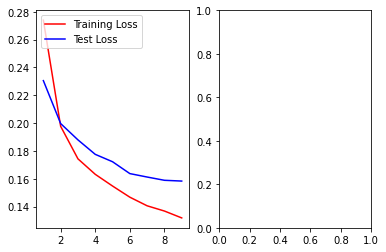

               precision    recall  f1-score   support

        toxic       0.72      0.47      0.57      6090
 severe_toxic       0.19      0.69      0.29       367
      obscene       0.73      0.50      0.59      3691
       threat       0.15      0.68      0.24       211
       insult       0.66      0.47      0.55      3427
identity_hate       0.37      0.32      0.35       712

    micro avg       0.59      0.48      0.53     14498
    macro avg       0.47      0.52      0.43     14498
 weighted avg       0.67      0.48      0.55     14498
  samples avg       0.04      0.04      0.03     14498

Epoch: 9 Train_Loss: 0.12779560094723144 Train_Accuracy: 0.9740512371063232
Epoch: 9 Test_Loss: 0.15631164821982385 Test_Accuracy: 0.9675435423851013


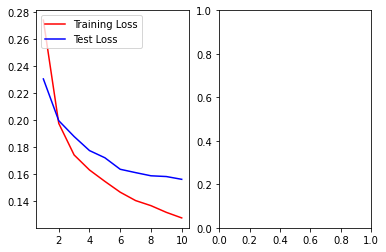

               precision    recall  f1-score   support

        toxic       0.69      0.52      0.59      6090
 severe_toxic       0.20      0.68      0.31       367
      obscene       0.71      0.54      0.61      3691
       threat       0.19      0.63      0.29       211
       insult       0.66      0.51      0.57      3427
identity_hate       0.45      0.28      0.35       712

    micro avg       0.60      0.51      0.56     14498
    macro avg       0.48      0.52      0.46     14498
 weighted avg       0.66      0.51      0.57     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 10 Train_Loss: 0.1243241914273359 Train_Accuracy: 0.9744909405708313
Epoch: 10 Test_Loss: 0.1519274715781212 Test_Accuracy: 0.9689399003982544


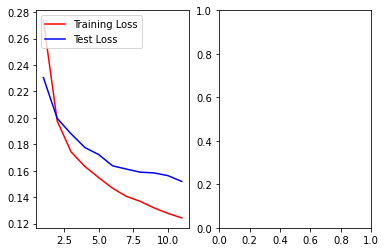

               precision    recall  f1-score   support

        toxic       0.66      0.56      0.60      6090
 severe_toxic       0.20      0.67      0.31       367
      obscene       0.66      0.59      0.62      3691
       threat       0.24      0.58      0.34       211
       insult       0.62      0.55      0.58      3427
identity_hate       0.36      0.38      0.37       712

    micro avg       0.58      0.56      0.57     14498
    macro avg       0.46      0.55      0.47     14498
 weighted avg       0.62      0.56      0.58     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 11 Train_Loss: 0.12154574471358688 Train_Accuracy: 0.9747374653816223
Epoch: 11 Test_Loss: 0.1512899938225746 Test_Accuracy: 0.9680203199386597


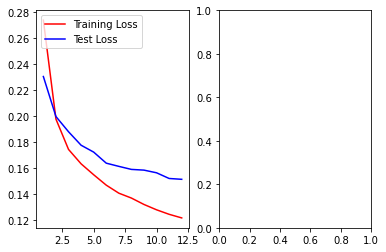

               precision    recall  f1-score   support

        toxic       0.76      0.48      0.58      6090
 severe_toxic       0.19      0.68      0.30       367
      obscene       0.74      0.52      0.61      3691
       threat       0.25      0.60      0.35       211
       insult       0.69      0.48      0.57      3427
identity_hate       0.41      0.34      0.37       712

    micro avg       0.63      0.49      0.55     14498
    macro avg       0.51      0.52      0.47     14498
 weighted avg       0.70      0.49      0.57     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 12 Train_Loss: 0.1192236150173136 Train_Accuracy: 0.9753296971321106
Epoch: 12 Test_Loss: 0.15476662915945053 Test_Accuracy: 0.9700626730918884


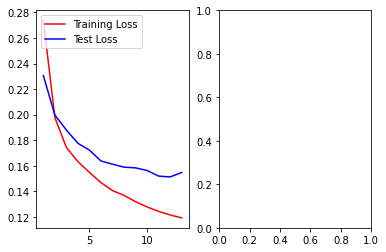

               precision    recall  f1-score   support

        toxic       0.70      0.53      0.60      6090
 severe_toxic       0.21      0.63      0.32       367
      obscene       0.71      0.56      0.63      3691
       threat       0.27      0.55      0.36       211
       insult       0.66      0.52      0.58      3427
identity_hate       0.28      0.48      0.35       712

    micro avg       0.60      0.53      0.57     14498
    macro avg       0.47      0.54      0.47     14498
 weighted avg       0.66      0.53      0.58     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 13 Train_Loss: 0.11705050160750173 Train_Accuracy: 0.9754257798194885
Epoch: 13 Test_Loss: 0.14847287672758103 Test_Accuracy: 0.968989372253418


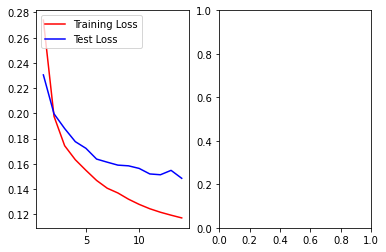

               precision    recall  f1-score   support

        toxic       0.69      0.56      0.62      6090
 severe_toxic       0.23      0.64      0.34       367
      obscene       0.70      0.58      0.64      3691
       threat       0.20      0.64      0.31       211
       insult       0.65      0.55      0.60      3427
identity_hate       0.33      0.46      0.39       712

    micro avg       0.60      0.56      0.58     14498
    macro avg       0.47      0.57      0.48     14498
 weighted avg       0.65      0.56      0.60     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 14 Train_Loss: 0.11406707618003473 Train_Accuracy: 0.9758403897285461
Epoch: 14 Test_Loss: 0.14474517232179643 Test_Accuracy: 0.9693306684494019


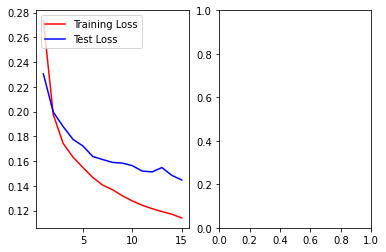

               precision    recall  f1-score   support

        toxic       0.69      0.55      0.61      6090
 severe_toxic       0.18      0.70      0.29       367
      obscene       0.70      0.58      0.64      3691
       threat       0.20      0.63      0.31       211
       insult       0.64      0.55      0.59      3427
identity_hate       0.31      0.47      0.38       712

    micro avg       0.58      0.56      0.57     14498
    macro avg       0.46      0.58      0.47     14498
 weighted avg       0.64      0.56      0.59     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 15 Train_Loss: 0.11327988016777314 Train_Accuracy: 0.9761443734169006
Epoch: 15 Test_Loss: 0.14899311658740044 Test_Accuracy: 0.9681140780448914


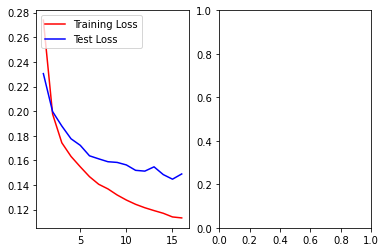

               precision    recall  f1-score   support

        toxic       0.68      0.57      0.62      6090
 severe_toxic       0.17      0.78      0.28       367
      obscene       0.66      0.62      0.64      3691
       threat       0.20      0.63      0.31       211
       insult       0.63      0.57      0.60      3427
identity_hate       0.39      0.41      0.40       712

    micro avg       0.57      0.58      0.57     14498
    macro avg       0.45      0.60      0.47     14498
 weighted avg       0.63      0.58      0.59     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 16 Train_Loss: 0.11073899264924993 Train_Accuracy: 0.9762331247329712
Epoch: 16 Test_Loss: 0.1490231149494648 Test_Accuracy: 0.9675748348236084


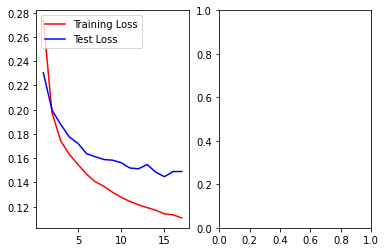

               precision    recall  f1-score   support

        toxic       0.72      0.54      0.62      6090
 severe_toxic       0.20      0.68      0.31       367
      obscene       0.72      0.58      0.64      3691
       threat       0.20      0.64      0.31       211
       insult       0.67      0.54      0.60      3427
identity_hate       0.32      0.49      0.38       712

    micro avg       0.60      0.55      0.58     14498
    macro avg       0.47      0.58      0.48     14498
 weighted avg       0.67      0.55      0.60     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 17 Train_Loss: 0.10871062614023685 Train_Accuracy: 0.9763919115066528
Epoch: 17 Test_Loss: 0.1462874998152256 Test_Accuracy: 0.9693228006362915


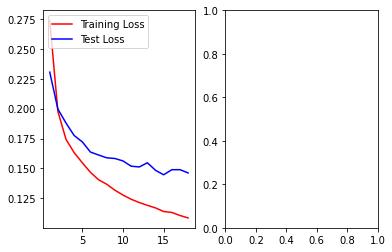

               precision    recall  f1-score   support

        toxic       0.72      0.53      0.62      6090
 severe_toxic       0.22      0.68      0.33       367
      obscene       0.72      0.58      0.64      3691
       threat       0.25      0.63      0.36       211
       insult       0.68      0.52      0.59      3427
identity_hate       0.38      0.41      0.39       712

    micro avg       0.63      0.54      0.58     14498
    macro avg       0.49      0.56      0.49     14498
 weighted avg       0.68      0.54      0.59     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 18 Train_Loss: 0.10668583194581935 Train_Accuracy: 0.976753294467926
Epoch: 18 Test_Loss: 0.144022008985281 Test_Accuracy: 0.9704430103302002


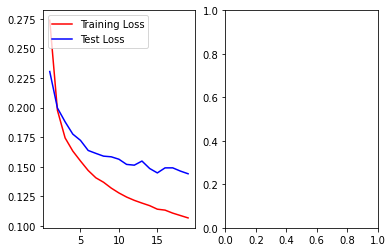

               precision    recall  f1-score   support

        toxic       0.71      0.55      0.62      6090
 severe_toxic       0.23      0.64      0.33       367
      obscene       0.72      0.58      0.64      3691
       threat       0.21      0.64      0.32       211
       insult       0.67      0.54      0.60      3427
identity_hate       0.41      0.40      0.40       712

    micro avg       0.62      0.55      0.58     14498
    macro avg       0.49      0.56      0.49     14498
 weighted avg       0.67      0.55      0.60     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 19 Train_Loss: 0.10544408127092399 Train_Accuracy: 0.9770237803459167
Epoch: 19 Test_Loss: 0.1454096401333809 Test_Accuracy: 0.9704039096832275


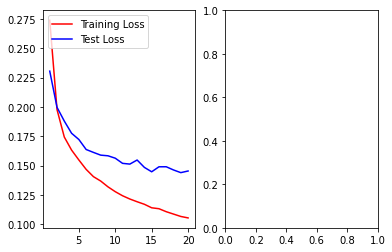

               precision    recall  f1-score   support

        toxic       0.74      0.53      0.62      6090
 severe_toxic       0.18      0.69      0.29       367
      obscene       0.74      0.57      0.65      3691
       threat       0.17      0.69      0.28       211
       insult       0.67      0.55      0.60      3427
identity_hate       0.41      0.42      0.41       712

    micro avg       0.61      0.55      0.58     14498
    macro avg       0.49      0.57      0.47     14498
 weighted avg       0.69      0.55      0.60     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 20 Train_Loss: 0.1037473233942038 Train_Accuracy: 0.9770958423614502
Epoch: 20 Test_Loss: 0.14594469672441482 Test_Accuracy: 0.969744861125946


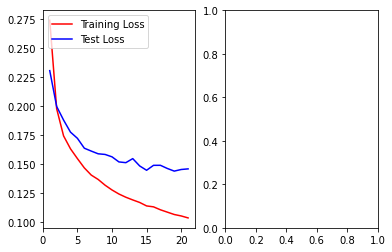

               precision    recall  f1-score   support

        toxic       0.63      0.62      0.63      6090
 severe_toxic       0.19      0.74      0.31       367
      obscene       0.65      0.66      0.65      3691
       threat       0.25      0.61      0.36       211
       insult       0.61      0.61      0.61      3427
identity_hate       0.31      0.49      0.38       712

    micro avg       0.56      0.63      0.59     14498
    macro avg       0.44      0.62      0.49     14498
 weighted avg       0.60      0.63      0.61     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 21 Train_Loss: 0.10275464889426263 Train_Accuracy: 0.9772462844848633
Epoch: 21 Test_Loss: 0.1481535528898239 Test_Accuracy: 0.9670903086662292


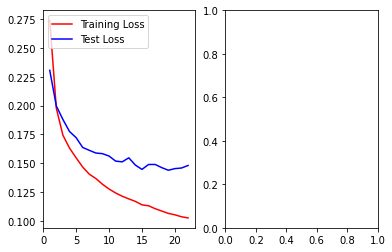

               precision    recall  f1-score   support

        toxic       0.64      0.62      0.63      6090
 severe_toxic       0.22      0.67      0.33       367
      obscene       0.68      0.63      0.66      3691
       threat       0.25      0.60      0.35       211
       insult       0.62      0.59      0.61      3427
identity_hate       0.33      0.49      0.39       712

    micro avg       0.58      0.61      0.59     14498
    macro avg       0.46      0.60      0.49     14498
 weighted avg       0.61      0.61      0.61     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 22 Train_Loss: 0.10073689281200178 Train_Accuracy: 0.9775596261024475
Epoch: 22 Test_Loss: 0.14627755326032638 Test_Accuracy: 0.9684839844703674


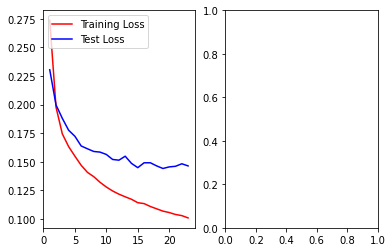

               precision    recall  f1-score   support

        toxic       0.67      0.60      0.64      6090
 severe_toxic       0.21      0.70      0.32       367
      obscene       0.71      0.62      0.66      3691
       threat       0.25      0.63      0.36       211
       insult       0.64      0.59      0.61      3427
identity_hate       0.31      0.52      0.39       712

    micro avg       0.59      0.60      0.60     14498
    macro avg       0.47      0.61      0.50     14498
 weighted avg       0.64      0.60      0.61     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 23 Train_Loss: 0.09982469700611173 Train_Accuracy: 0.9777215123176575
Epoch: 23 Test_Loss: 0.14291855409741402 Test_Accuracy: 0.9692863821983337


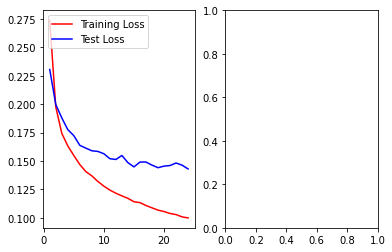

               precision    recall  f1-score   support

        toxic       0.55      0.70      0.62      6090
 severe_toxic       0.18      0.74      0.29       367
      obscene       0.54      0.72      0.62      3691
       threat       0.28      0.58      0.38       211
       insult       0.51      0.69      0.58      3427
identity_hate       0.36      0.47      0.41       712

    micro avg       0.50      0.69      0.58     14498
    macro avg       0.40      0.65      0.48     14498
 weighted avg       0.52      0.69      0.59     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 24 Train_Loss: 0.09864802522441515 Train_Accuracy: 0.977843701839447
Epoch: 24 Test_Loss: 0.1602642353475094 Test_Accuracy: 0.9619140028953552


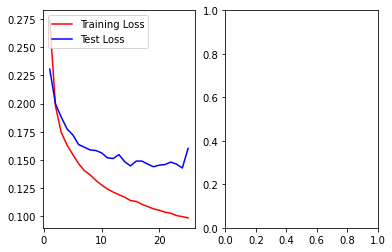

               precision    recall  f1-score   support

        toxic       0.67      0.60      0.63      6090
 severe_toxic       0.20      0.68      0.31       367
      obscene       0.70      0.62      0.66      3691
       threat       0.19      0.68      0.30       211
       insult       0.66      0.58      0.62      3427
identity_hate       0.33      0.51      0.40       712

    micro avg       0.59      0.60      0.59     14498
    macro avg       0.46      0.61      0.49     14498
 weighted avg       0.64      0.60      0.61     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 25 Train_Loss: 0.09739401667283322 Train_Accuracy: 0.978119432926178
Epoch: 25 Test_Loss: 0.1440227605998516 Test_Accuracy: 0.968848705291748


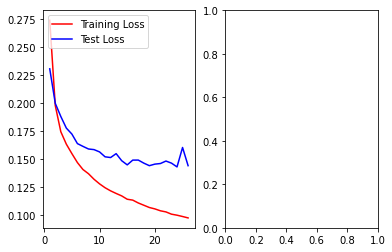

               precision    recall  f1-score   support

        toxic       0.63      0.63      0.63      6090
 severe_toxic       0.22      0.73      0.34       367
      obscene       0.65      0.66      0.65      3691
       threat       0.20      0.68      0.31       211
       insult       0.60      0.62      0.61      3427
identity_hate       0.32      0.52      0.39       712

    micro avg       0.56      0.63      0.59     14498
    macro avg       0.44      0.64      0.49     14498
 weighted avg       0.60      0.63      0.61     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 26 Train_Loss: 0.09643734364101711 Train_Accuracy: 0.9781716465950012
Epoch: 26 Test_Loss: 0.14649870932102205 Test_Accuracy: 0.967155396938324


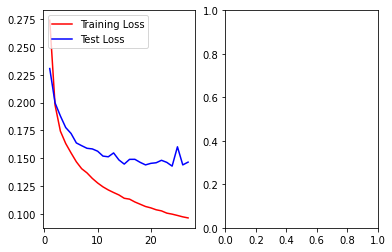

               precision    recall  f1-score   support

        toxic       0.55      0.71      0.62      6090
 severe_toxic       0.18      0.73      0.29       367
      obscene       0.56      0.71      0.62      3691
       threat       0.14      0.72      0.24       211
       insult       0.53      0.67      0.59      3427
identity_hate       0.23      0.59      0.33       712

    micro avg       0.47      0.69      0.56     14498
    macro avg       0.36      0.69      0.45     14498
 weighted avg       0.51      0.69      0.58     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 27 Train_Loss: 0.09562321333811642 Train_Accuracy: 0.9783210158348083
Epoch: 27 Test_Loss: 0.1628641414642334 Test_Accuracy: 0.9591318368911743


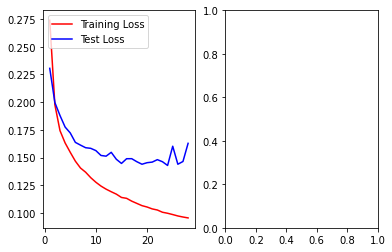

               precision    recall  f1-score   support

        toxic       0.62      0.64      0.63      6090
 severe_toxic       0.18      0.74      0.29       367
      obscene       0.61      0.68      0.64      3691
       threat       0.21      0.66      0.32       211
       insult       0.56      0.65      0.60      3427
identity_hate       0.33      0.52      0.41       712

    micro avg       0.53      0.65      0.59     14498
    macro avg       0.42      0.65      0.48     14498
 weighted avg       0.57      0.65      0.60     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 28 Train_Loss: 0.0941621695454113 Train_Accuracy: 0.978493332862854
Epoch: 28 Test_Loss: 0.15021870669722556 Test_Accuracy: 0.9652354717254639


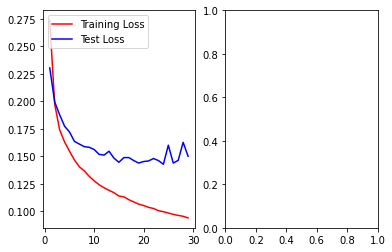

               precision    recall  f1-score   support

        toxic       0.65      0.62      0.63      6090
 severe_toxic       0.16      0.78      0.27       367
      obscene       0.65      0.65      0.65      3691
       threat       0.23      0.67      0.34       211
       insult       0.61      0.61      0.61      3427
identity_hate       0.28      0.55      0.37       712

    micro avg       0.54      0.63      0.58     14498
    macro avg       0.43      0.65      0.48     14498
 weighted avg       0.61      0.63      0.61     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 29 Train_Loss: 0.09363947107862586 Train_Accuracy: 0.9785685539245605
Epoch: 29 Test_Loss: 0.1490028204023838 Test_Accuracy: 0.9661211967468262


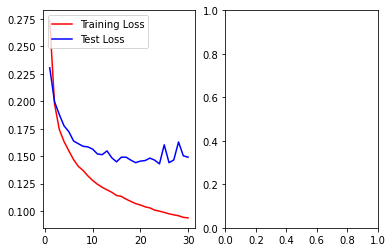

               precision    recall  f1-score   support

        toxic       0.62      0.65      0.63      6090
 severe_toxic       0.25      0.67      0.36       367
      obscene       0.65      0.67      0.66      3691
       threat       0.21      0.67      0.32       211
       insult       0.62      0.61      0.61      3427
identity_hate       0.36      0.48      0.41       712

    micro avg       0.57      0.64      0.60     14498
    macro avg       0.45      0.63      0.50     14498
 weighted avg       0.60      0.64      0.61     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 30 Train_Loss: 0.09233092968590939 Train_Accuracy: 0.9783993363380432
Epoch: 30 Test_Loss: 0.14498530608415602 Test_Accuracy: 0.9681766033172607


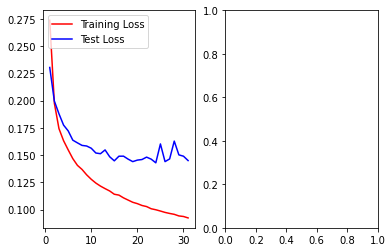

               precision    recall  f1-score   support

        toxic       0.62      0.66      0.64      6090
 severe_toxic       0.22      0.68      0.33       367
      obscene       0.66      0.66      0.66      3691
       threat       0.25      0.65      0.36       211
       insult       0.60      0.64      0.62      3427
identity_hate       0.22      0.64      0.33       712

    micro avg       0.54      0.65      0.59     14498
    macro avg       0.43      0.65      0.49     14498
 weighted avg       0.59      0.65      0.61     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 31 Train_Loss: 0.09062983829360934 Train_Accuracy: 0.9788620471954346
Epoch: 31 Test_Loss: 0.1473337074816227 Test_Accuracy: 0.9660899639129639


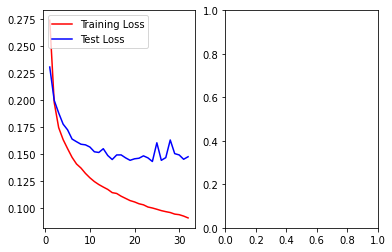

               precision    recall  f1-score   support

        toxic       0.64      0.65      0.64      6090
 severe_toxic       0.22      0.70      0.33       367
      obscene       0.66      0.65      0.66      3691
       threat       0.22      0.63      0.33       211
       insult       0.60      0.64      0.62      3427
identity_hate       0.26      0.59      0.36       712

    micro avg       0.56      0.64      0.60     14498
    macro avg       0.44      0.64      0.49     14498
 weighted avg       0.60      0.64      0.62     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 32 Train_Loss: 0.08972134859038469 Train_Accuracy: 0.9787931442260742
Epoch: 32 Test_Loss: 0.14578149154782294 Test_Accuracy: 0.9671971201896667


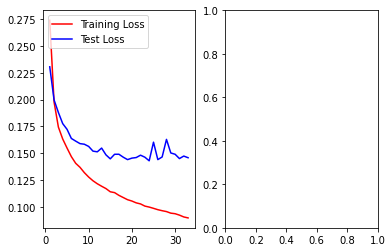

               precision    recall  f1-score   support

        toxic       0.65      0.63      0.64      6090
 severe_toxic       0.21      0.73      0.32       367
      obscene       0.67      0.65      0.66      3691
       threat       0.23      0.62      0.33       211
       insult       0.62      0.63      0.62      3427
identity_hate       0.29      0.54      0.38       712

    micro avg       0.57      0.63      0.60     14498
    macro avg       0.44      0.63      0.49     14498
 weighted avg       0.61      0.63      0.62     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 33 Train_Loss: 0.09072280804722165 Train_Accuracy: 0.9786604642868042
Epoch: 33 Test_Loss: 0.14673762542009353 Test_Accuracy: 0.9679656028747559


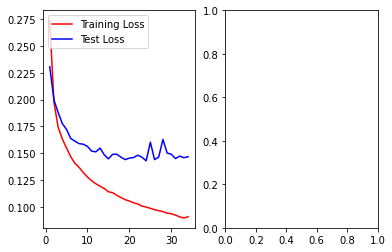

               precision    recall  f1-score   support

        toxic       0.65      0.63      0.64      6090
 severe_toxic       0.22      0.71      0.34       367
      obscene       0.69      0.64      0.66      3691
       threat       0.21      0.68      0.32       211
       insult       0.65      0.59      0.62      3427
identity_hate       0.35      0.48      0.41       712

    micro avg       0.59      0.62      0.60     14498
    macro avg       0.46      0.62      0.50     14498
 weighted avg       0.63      0.62      0.62     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 34 Train_Loss: 0.08923175098756567 Train_Accuracy: 0.9788244366645813
Epoch: 34 Test_Loss: 0.14578152480721474 Test_Accuracy: 0.969202995300293


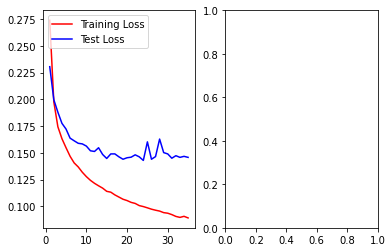

               precision    recall  f1-score   support

        toxic       0.65      0.63      0.64      6090
 severe_toxic       0.22      0.69      0.33       367
      obscene       0.67      0.65      0.66      3691
       threat       0.22      0.66      0.33       211
       insult       0.63      0.61      0.62      3427
identity_hate       0.33      0.52      0.41       712

    micro avg       0.58      0.63      0.60     14498
    macro avg       0.46      0.63      0.50     14498
 weighted avg       0.62      0.63      0.62     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 35 Train_Loss: 0.0877099100034684 Train_Accuracy: 0.9791712164878845
Epoch: 35 Test_Loss: 0.14410955226421357 Test_Accuracy: 0.9688538908958435


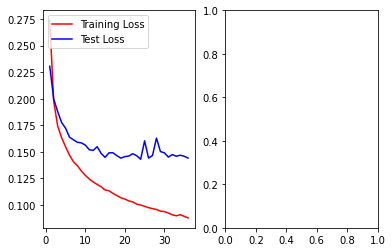

               precision    recall  f1-score   support

        toxic       0.62      0.67      0.64      6090
 severe_toxic       0.18      0.75      0.29       367
      obscene       0.63      0.69      0.66      3691
       threat       0.21      0.63      0.32       211
       insult       0.59      0.65      0.62      3427
identity_hate       0.36      0.49      0.42       712

    micro avg       0.55      0.66      0.60     14498
    macro avg       0.43      0.65      0.49     14498
 weighted avg       0.59      0.66      0.62     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 36 Train_Loss: 0.08743074039021173 Train_Accuracy: 0.9791095852851868
Epoch: 36 Test_Loss: 0.148072915494442 Test_Accuracy: 0.9666682481765747


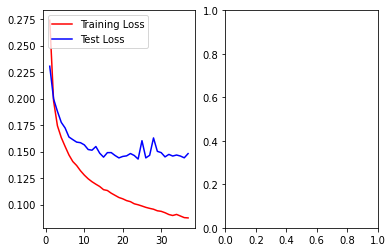

               precision    recall  f1-score   support

        toxic       0.71      0.58      0.64      6090
 severe_toxic       0.22      0.70      0.34       367
      obscene       0.72      0.62      0.66      3691
       threat       0.27      0.64      0.38       211
       insult       0.68      0.57      0.62      3427
identity_hate       0.36      0.51      0.42       712

    micro avg       0.62      0.59      0.60     14498
    macro avg       0.49      0.60      0.51     14498
 weighted avg       0.67      0.59      0.62     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 37 Train_Loss: 0.08638207306965995 Train_Accuracy: 0.9792975783348083
Epoch: 37 Test_Loss: 0.14632921317219735 Test_Accuracy: 0.9709457755088806


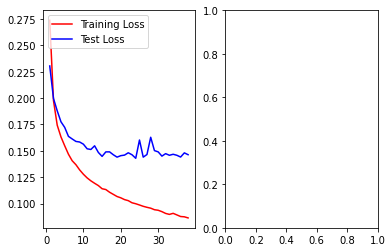

               precision    recall  f1-score   support

        toxic       0.69      0.60      0.64      6090
 severe_toxic       0.26      0.63      0.37       367
      obscene       0.73      0.62      0.67      3691
       threat       0.25      0.62      0.36       211
       insult       0.69      0.56      0.62      3427
identity_hate       0.50      0.38      0.43       712

    micro avg       0.64      0.58      0.61     14498
    macro avg       0.52      0.57      0.51     14498
 weighted avg       0.67      0.58      0.62     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 38 Train_Loss: 0.08534589853997414 Train_Accuracy: 0.9795252680778503
Epoch: 38 Test_Loss: 0.14772335329651834 Test_Accuracy: 0.9720555543899536


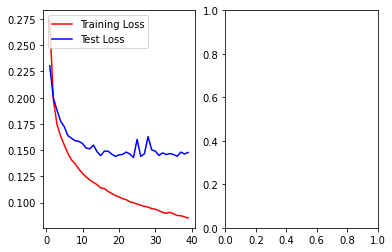

               precision    recall  f1-score   support

        toxic       0.61      0.67      0.64      6090
 severe_toxic       0.20      0.71      0.32       367
      obscene       0.63      0.68      0.65      3691
       threat       0.26      0.64      0.37       211
       insult       0.59      0.64      0.62      3427
identity_hate       0.34      0.50      0.41       712

    micro avg       0.55      0.66      0.60     14498
    macro avg       0.44      0.64      0.50     14498
 weighted avg       0.58      0.66      0.61     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 39 Train_Loss: 0.0841539157435107 Train_Accuracy: 0.9795618653297424
Epoch: 39 Test_Loss: 0.15092058274149894 Test_Accuracy: 0.967072069644928


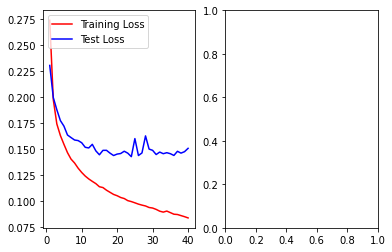

               precision    recall  f1-score   support

        toxic       0.66      0.63      0.64      6090
 severe_toxic       0.24      0.67      0.35       367
      obscene       0.68      0.65      0.66      3691
       threat       0.33      0.63      0.43       211
       insult       0.64      0.61      0.62      3427
identity_hate       0.41      0.43      0.42       712

    micro avg       0.61      0.62      0.61     14498
    macro avg       0.49      0.60      0.52     14498
 weighted avg       0.63      0.62      0.62     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 40 Train_Loss: 0.08295560163708451 Train_Accuracy: 0.9797738790512085
Epoch: 40 Test_Loss: 0.15021433770656586 Test_Accuracy: 0.9704924821853638


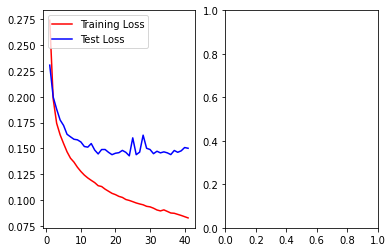

               precision    recall  f1-score   support

        toxic       0.59      0.69      0.64      6090
 severe_toxic       0.18      0.72      0.29       367
      obscene       0.61      0.69      0.65      3691
       threat       0.14      0.74      0.23       211
       insult       0.55      0.67      0.60      3427
identity_hate       0.26      0.57      0.36       712

    micro avg       0.50      0.68      0.58     14498
    macro avg       0.39      0.68      0.46     14498
 weighted avg       0.55      0.68      0.60     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 41 Train_Loss: 0.08464911170542622 Train_Accuracy: 0.9795628786087036
Epoch: 41 Test_Loss: 0.15506135433912277 Test_Accuracy: 0.9625757336616516


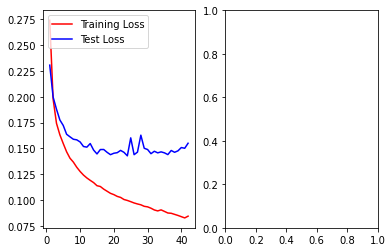

               precision    recall  f1-score   support

        toxic       0.63      0.67      0.65      6090
 severe_toxic       0.18      0.75      0.29       367
      obscene       0.65      0.66      0.66      3691
       threat       0.22      0.66      0.33       211
       insult       0.60      0.64      0.62      3427
identity_hate       0.33      0.52      0.40       712

    micro avg       0.55      0.66      0.60     14498
    macro avg       0.43      0.65      0.49     14498
 weighted avg       0.59      0.66      0.62     14498
  samples avg       0.05      0.06      0.05     14498

Epoch: 42 Train_Loss: 0.08335411054297136 Train_Accuracy: 0.9796078205108643
Epoch: 42 Test_Loss: 0.15116786712408065 Test_Accuracy: 0.9668636322021484


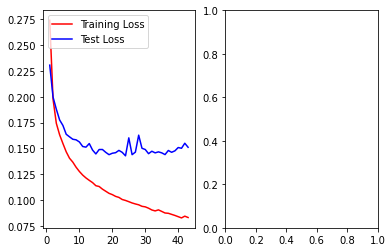

               precision    recall  f1-score   support

        toxic       0.70      0.59      0.64      6090
 severe_toxic       0.22      0.70      0.33       367
      obscene       0.72      0.62      0.67      3691
       threat       0.28      0.63      0.39       211
       insult       0.68      0.56      0.62      3427
identity_hate       0.40      0.45      0.42       712

    micro avg       0.63      0.59      0.61     14498
    macro avg       0.50      0.59      0.51     14498
 weighted avg       0.67      0.59      0.62     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 43 Train_Loss: 0.0821850728840591 Train_Accuracy: 0.9798898100852966
Epoch: 43 Test_Loss: 0.1523905239403248 Test_Accuracy: 0.9711750149726868


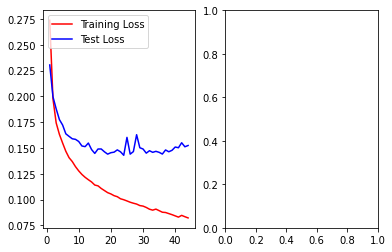

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
for cls in classes:
    w = len(df) /df[cls].sum()
    weights.append(w)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(weight_set))
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor((175796 - 35098*2) / 35098*2))
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=128)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    # model = torch.nn.DataParallel(model)    # multi-gpu

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.0001)

epochs = 50

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        #print('ids: ', ids.shape)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        # if batch_id % 100 == 0:
            # print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    if e % 3000 == 0 and e != 0:
        torch.save(model.state_dict(), 'model_epoch_{}.pt'.format(e))

    ## Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        predictions_store = []
        labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                predictions_store.append(preds[i])
                labels_store.append(labels[i])

        # print(pred_counter, label_counter)
        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        test_losses[e] = test_loss

        rp = classification_report(labels_store, predictions_store, target_names=classes)
        print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, accuracy))

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")

        plt.show()





In [ ]:
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {} Recall: {} Precision: {}'.format(e, test_loss, accuracy, recall_score, precision_score))
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")


        ax2.plot(epoch_count, recalls, 'g', label='Recall')
        ax2.legend(loc="upper left")

        plt.show()

In [ ]:
probs = torch.sigmoid(logits)
print(probs)